# Introduction

This notebook seeks to recommend iOS mobile apps in Apple Store for users based on a dataset collected using the iTunes Search API. The dataset contains user ratings for over 7000 mobiles apps. 

The recommender is a simple recommender system without using any collaborative filtering techniques. It uses Bayesian bandit to solve the explore-exploit problem. For setup, it initializes every app as a beta bandit ($\alpha$ = $\beta$ = 1), then updates the app's parameters using every single rating of the app. For future recommendations, it recommends the *argmax* of the samples collected from each beta distribution, and updates its parameters using the new rating.

# Data Proprocessing

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
apps = pd.read_csv("datasets_30069_39285_AppleStore.csv")
apps.drop(['Unnamed: 0', 'size_bytes', 'currency', 'rating_count_ver', 'user_rating_ver', 
           'ver', 'cont_rating', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic'], axis=1, inplace=True)
apps.head(5)

,id,track_name,price,rating_count_tot,user_rating,prime_genre
0,281656475,PAC-MAN Premium,3.99,21292,4.0,Games
1,281796108,Evernote - stay organized,0.00,161065,4.0,Productivity
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",0.00,188583,3.5,Weather
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",0.00,262241,4.0,Shopping
4,282935706,Bible,0.00,985920,4.5,Reference


In [3]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7197 non-null   int64  
 1   track_name        7197 non-null   object 
 2   price             7197 non-null   float64
 3   rating_count_tot  7197 non-null   int64  
 4   user_rating       7197 non-null   float64
 5   prime_genre       7197 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 337.5+ KB


# Bayesian Bandit

In [4]:
from scipy.stats import beta

class BayesianBandit(object):
    def __init__(self):
        self.a = 1
        self.b = 1
    
    def sample(self):
        return np.random.beta(self.a, self.b)
    
    def pull(self, p):
        assert p <= 1
        return np.random.random() * p
    
    def update(self, x):
        self.a += x
        self.b += 1 - x

In [5]:
appCount = apps.shape[0]
bandits = [BayesianBandit() for i in range(appCount)]

In [6]:
def setup():
    for index, row in apps.iterrows():
        iterNum = row['rating_count_tot']
        rating = row['user_rating']

        for _ in range(iterNum):
            bandits[index].update(rating / 5)

        if index % 1000 == 0:
            print("{0}/{1} app data setup".format(index, appCount))

setup()

0/7197 app data setup
1000/7197 app data setup
2000/7197 app data setup
3000/7197 app data setup
4000/7197 app data setup
5000/7197 app data setup
6000/7197 app data setup
7000/7197 app data setup


# Recommendation

bestSample is: 0.999999355227772
Despicable Bear - Top Beat Action Game recommanded. Simulation response rating is 3.5.


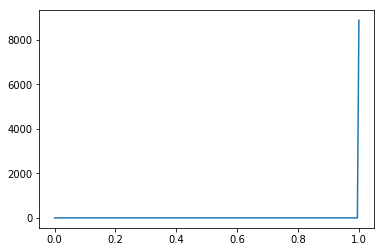

bestSample is: 0.9999999103178528
CARROT To-Do - Talking Task List recommanded. Simulation response rating is 4.


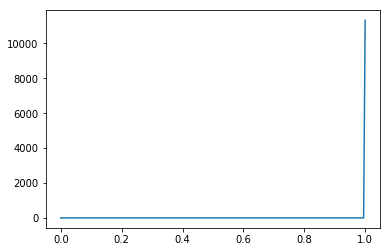

bestSample is: 0.9999982612591806
Optical Inquisitor 17+ recommanded. Simulation response rating is 4.


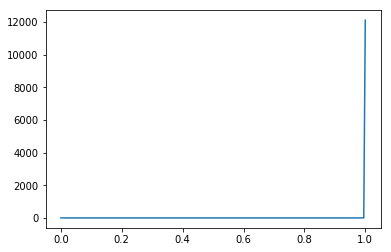

bestSample is: 0.9999992141529493
We Heart It - Fashion, wallpapers, quotes, tattoos recommanded. Simulation response rating is 4.5.


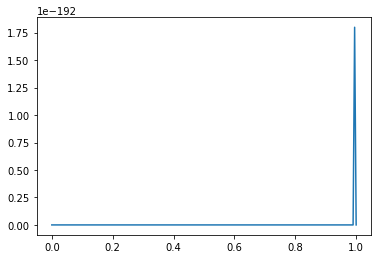

bestSample is: 0.9999989603053712
NOAA Hi-Def Radar Pro -  Storm Warnings, Hurricane Tracker & Weather Forecast recommanded. Simulation response rating is 3.5.


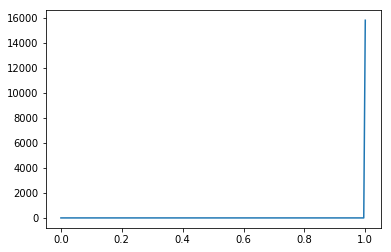

bestSample is: 0.9999997800170082
Suрer Toss The Turtle recommanded. Simulation response rating is 5.


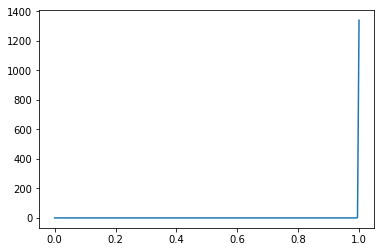

bestSample is: 0.9999988683157353
Egg, Inc. recommanded. Simulation response rating is 4.


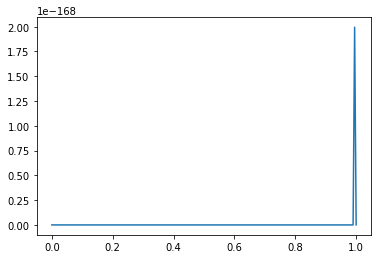

bestSample is: 0.999999860570617
Lewandowski: Football Star recommanded. Simulation response rating is 4.


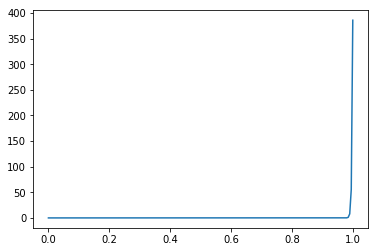

bestSample is: 0.9999989572151395
Geometry Dash recommanded. Simulation response rating is 3.


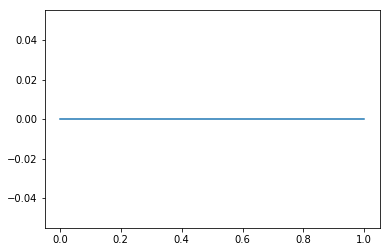

bestSample is: 0.9999999603821297
Fish Mania™ recommanded. Simulation response rating is 1.5.


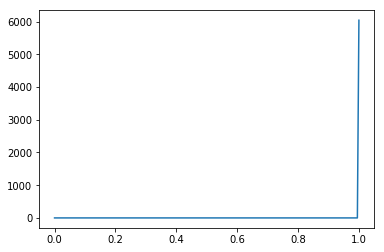

In [14]:
def plot(bandit):
    x = np.linspace(0, 1, 200)
    y = beta.pdf(x, bandit.a, bandit.b)
    plt.plot(x, y)
    plt.show()
    

def recommand(ratingResSeq):
    for rating in ratingResSeq:
        sampleLst = []
        bestSample = -1
        bestSampleIdx = None
        
        # Get samples
        for idx, bandit in enumerate(bandits):
            sample = bandit.sample()
            sampleLst.append(sample)

            if sample >= bestSample:
                bestSampleIdx = idx
                bestSample = sample
        
        # Recommend the best sample
        print("bestSample is: {}".format(bestSample))
        print("{0} recommanded. Simulation response rating is {1}.".format(
            apps.iloc[bestSampleIdx]['track_name'],
            rating)
        )
        plot(bandits[bestSampleIdx])
        
        # Update the bandit that gives the best sample
        reward = bandits[bestSampleIdx].pull(rating / 5)
        bandits[bestSampleIdx].update(reward)

recommand([3.5, 4, 4, 4.5, 3.5, 5, 4, 4, 3, 1.5])

The recommended apps are of either one of the two types:
* An app that has average ratings = 5 and has numerous (> 5000) ratings
* An app that has 0 ratings, but the random sampling out of the distribution is extremely close to 1 (extremely lucky).

# Conclusion

The Bayesian Bandit is a popular choice to find the balance in the explore-exploit problem, and in this project, it is shown convenient to be set up on existing ratings, and powerful on recommending items in the future.